# Set up to use `gplite` in Jupyter Notebooks

Set up the magic commands for R.

In [1]:
%load_ext rpy2.ipython

Improve image quality of `matplotlib` output.

In [2]:
%config InlineBackend.figure_format='retina'

Load the required R libraries.

In [3]:
%%R
library(gplite)
library(ggplot2)

This is gplite version 0.13.0


## Previous `gplite` example

Generate the required data.

In [4]:
%%R -o x -o y
x <- seq(from = -2, to = 2, by = 1)
y <- x^2

Initialize, run the model, and plot.

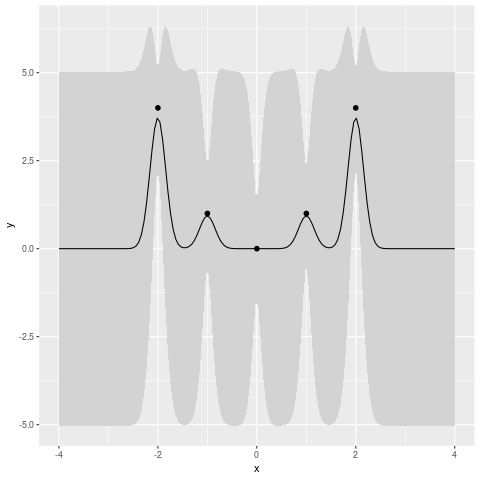

In [5]:
%%R
# Specify the GP model we want to use:
gp_empty <- gp_init(
  
  # A squared exponential (aka Gaussian aka RBF) kernel
  cfs = cf_sexp(
    vars = NULL,
    lscale = 0.3,
    magn = 1,
    prior_lscale = prior_logunif(),
    prior_magn = prior_logunif(),
    normalize = FALSE
  ),  
  
  # Assume Gaussian distributed errors
  lik = lik_gaussian(
    sigma = 0.5, 
    prior_sigma = prior_logunif()
  ), 
  
  # Use the full covariance (i.e., do not approximate)
  method = method_full() 
  
)

# Now fit the model to the data:
gp_optimized <- gp_optim(gp_empty, x, y, verbose = FALSE)

# compute the predictive mean and variance in a grid of points
xt   <- seq(-4, 4, len=150)
pred <- gp_pred(gp_optimized, xt, var = T)

# visualize
mu <- pred$mean
lb <- pred$mean - 2*sqrt(pred$var)
ub <- pred$mean + 2*sqrt(pred$var)

ggplot() + 
  geom_ribbon(aes(x=xt, ymin=lb, ymax=ub), fill='lightgray') +
  geom_line(aes(x=xt, y=mu), linewidth = 0.5) +
  geom_point(aes(x=x, y=y), size=2) +
  xlab('x') + ylab('y')

# GPFlow

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf
import tensorflow_probability 

2025-11-19 03:11:45.832545: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 03:11:45.833371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 03:11:45.873039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 03:11:47.159833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Generate the same data for `gpflow` as for `gplite`.

In [7]:
x = np.array(
    [
    [2.],
    [1.],
    [0.],
    [-1],
    [-2]
])

y = x**2

In [8]:
x

array([[ 2.],
       [ 1.],
       [ 0.],
       [-1.],
       [-2.]])

In [9]:
y

array([[4.],
       [1.],
       [0.],
       [1.],
       [4.]])

Plot the data.

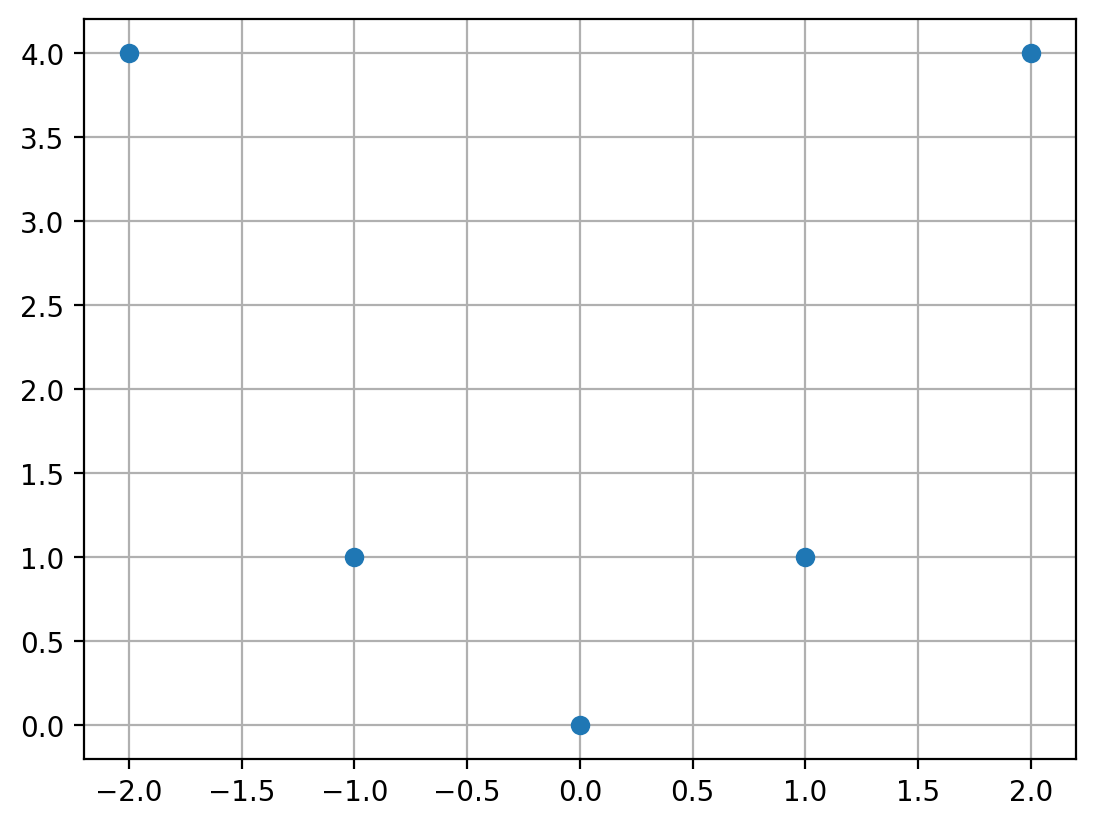

In [10]:
fig, ax = plt.subplots()
ax.scatter(x, y, zorder=2)
ax.grid(True)
plt.show()

Let us try to recapitulate the above graph using `gpflow`. The settings for `gplite` above were:
* a squared exponential kernel
    * the length scale initial value was 0.3
    * the magnitude (function variance) initial value was 1
    * the prior on the length scale was log uniform
    * the prior on the magnitude was log uniform
* Gaussian distributed error
    * the error initial value was 0.5
    * the prior on the error was log uniform
* Full covariance

TensorFlow Probabilities does not have a log uniform distribution. Therefore, we will need to generate that distribution ourselves. Let us first take the simple case of the uniform distribution.

In [11]:
# starting with a squared exponential distribution
# with variance 1 and length scale 0.3 as above
se_kernel = gpflow.kernels.SquaredExponential(
    variance = 1,
    lengthscales = 0.3
)

# setting a uniform prior on both
se_kernel.variance.prior = tensorflow_probability.distributions.Uniform(
    low = gpflow.utilities.to_default_float(0),
    high = gpflow.utilities.to_default_float(1)
)
se_kernel.lengthscales.prior = tensorflow_probability.distributions.Uniform(
    low = gpflow.utilities.to_default_float(0),
    high = gpflow.utilities.to_default_float(1)
)

2025-11-19 03:11:48.857459: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
# setting the prior on the likelihood
likelihood = gpflow.likelihoods.Gaussian(
    variance = 0.5**2
)

# set a prior
likelihood.variance.prior = tensorflow_probability.distributions.Uniform(
    low = gpflow.utilities.to_default_float(0),
    high = gpflow.utilities.to_default_float(1)
)

In [13]:
se_kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,Uniform,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Softplus,Uniform,True,(),float64,0.3


In [14]:
likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + Shift,Uniform,True,(),float64,0.25


In [15]:
nm_model = gpflow.models.GPR(
    data = (x, y),
    kernel = se_kernel,
    likelihood = likelihood
)

In [16]:
# optimize using Nelder-Mead
opt = gpflow.optimizers.Scipy()
opt.minimize(
    nm_model.training_loss,
    nm_model.trainable_variables,
    method = 'Nelder-Mead'
)

/usr/local/lib/python3.11/dist-packages/gpflow/optimizers/scipy.py:159: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  opt_result = scipy.optimize.minimize(


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14.240526583011755
             x: [ 4.649e-01  5.205e-01  5.413e-01]
           nit: 135
          nfev: 261
 final_simplex: (array([[ 4.649e-01,  5.205e-01,  5.413e-01],
                       [ 4.649e-01,  5.205e-01,  5.413e-01],
                       [ 4.650e-01,  5.205e-01,  5.413e-01],
                       [ 4.650e-01,  5.205e-01,  5.413e-01]]), array([ 1.424e+01,  1.424e+01,  1.424e+01,  1.424e+01]))

Make predictions using the model

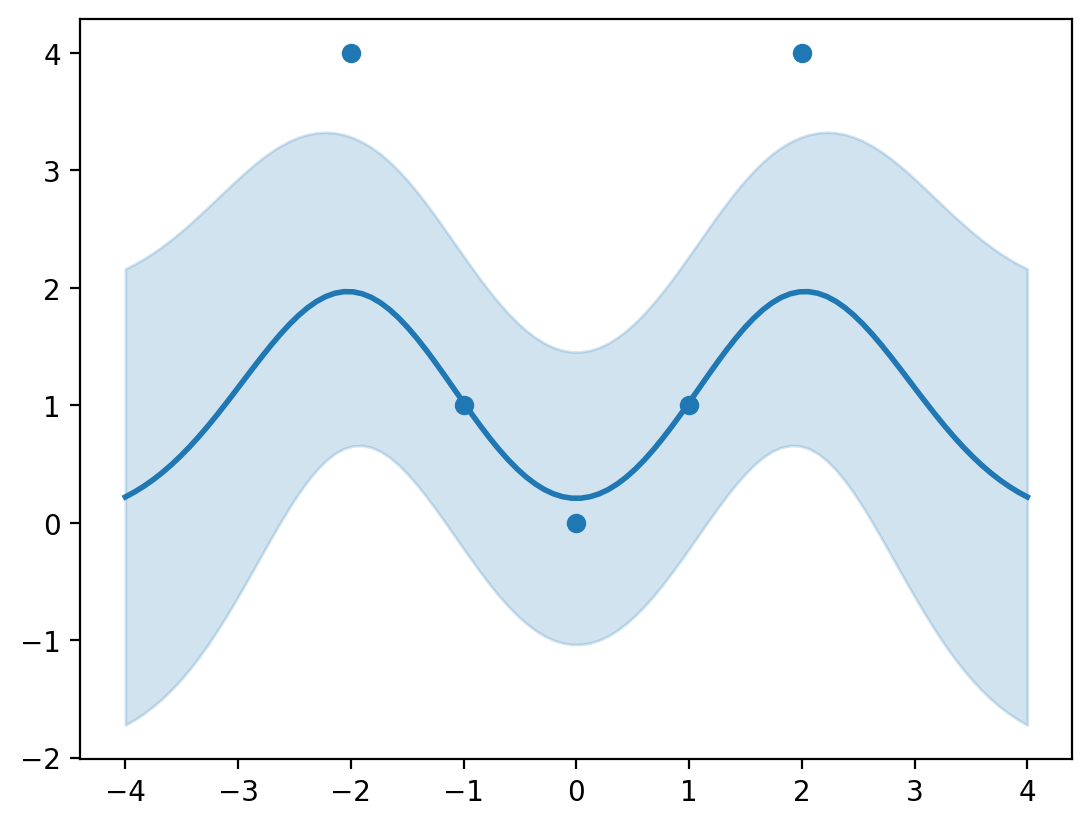

In [17]:
xx = np.linspace(-4, 4, 100).reshape(100,1)
mean, var = nm_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2
)

Does this look different because it is the uniform distribution and not the log uniform distribution?

Create a log uniform distribution.

In [18]:
log_uniform = tensorflow_probability.distributions.TransformedDistribution(
    distribution = tensorflow_probability.distributions.Uniform(low = np.log(0.1), high = np.log(1)),
    bijector = tensorflow_probability.bijectors.Exp()
)

(array([2873., 1695., 1171.,  928.,  780.,  634.,  583.,  495.,  445.,
         396.]),
 array([0.10001064, 0.190008  , 0.28000536, 0.37000272, 0.46000007,
        0.54999743, 0.63999479, 0.72999215, 0.8199895 , 0.90998686,
        0.99998422]),
 <BarContainer object of 10 artists>)

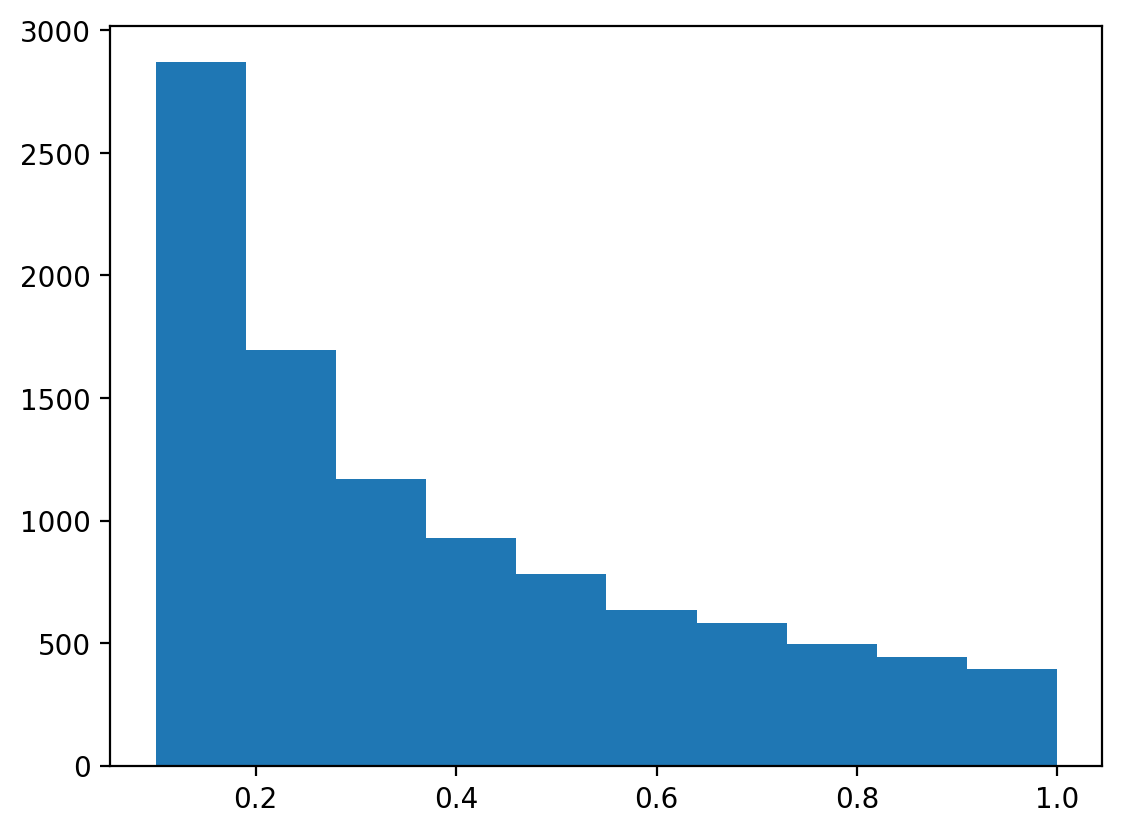

In [19]:
plt.hist(log_uniform.sample(10000))

In [20]:
def log_uniform_dist(x, low = 1, high = 4):
    return 1 / (x * np.log(high/low))

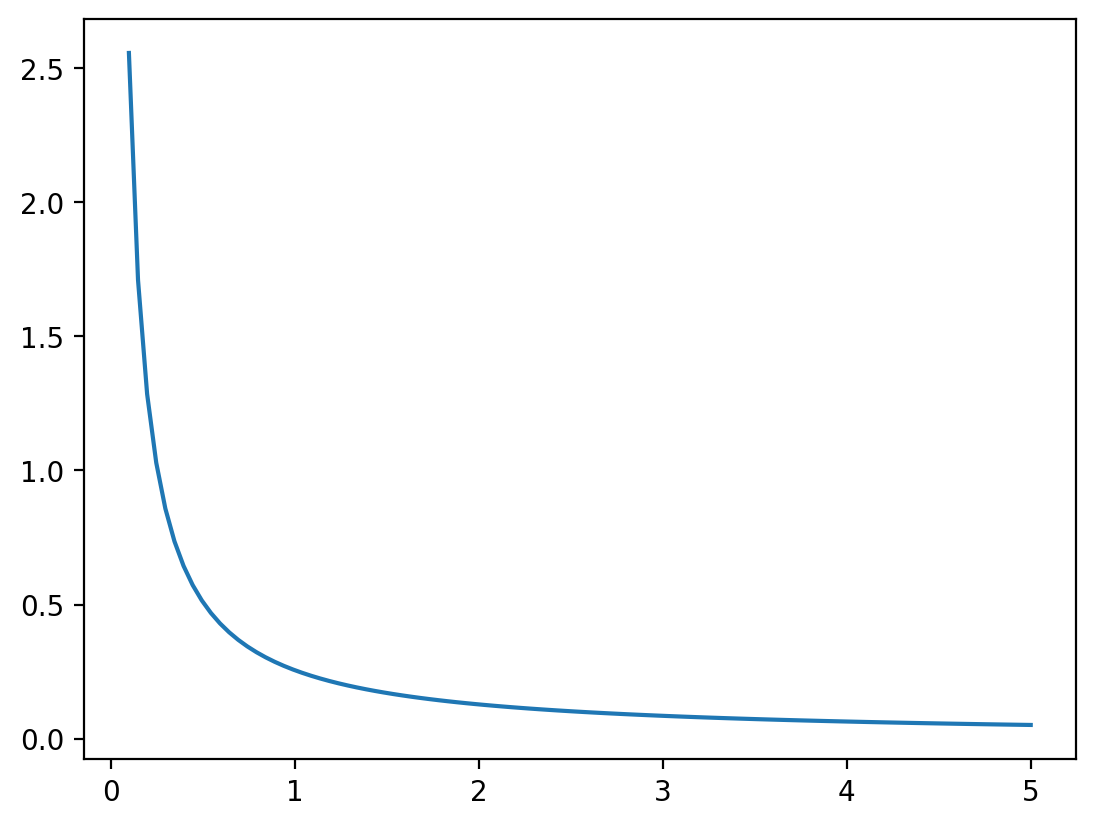

In [21]:
x_plot = np.linspace(0.1, 5, 100)
plt.plot(x_plot, log_uniform_dist(x_plot, low = 0.1, high = 5))

We can use this new distribution as the priors.

In [22]:
# starting with a squared exponential distribution
# with variance 1 and length scale 0.3 as above
se_kernel = gpflow.kernels.SquaredExponential(
    variance = 1,
    lengthscales = 0.3
)

# setting a uniform prior on both
se_kernel.variance.prior = log_uniform
se_kernel.lengthscales.prior = log_uniform

# setting the prior on the likelihood
likelihood = gpflow.likelihoods.Gaussian(
    variance = 0.5**2
)

# set a prior
likelihood.variance.prior = log_uniform

nm_model = gpflow.models.GPR(
    data = (x, y),
    kernel = se_kernel,
    likelihood = likelihood
)

nm_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,expUniform,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,expUniform,True,(),float64,0.3
GPR.likelihood.variance,Parameter,Softplus + Shift,expUniform,True,(),float64,0.25


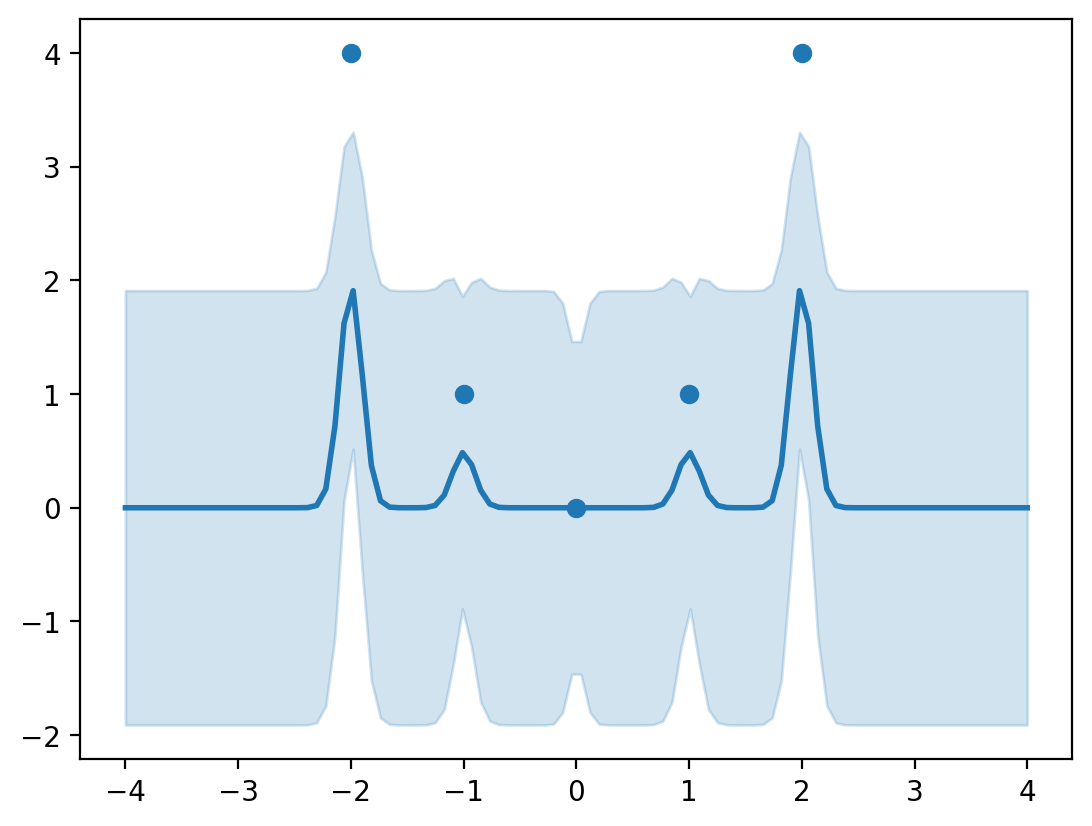

In [23]:
# optimize using Nelder-Mead
opt = gpflow.optimizers.Scipy()
opt.minimize(
    nm_model.training_loss,
    nm_model.trainable_variables,
    method = 'Nelder-Mead'
)

xx = np.linspace(-4, 4, 100).reshape(100,1)
mean, var = nm_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2
)

Most of the shape of the above is driven by the length scale parameter.